# Fabricating transportability issue by training and predicting on different data - leave one country out for training and use it for prediction. 
References: <br>
zhou 2023 circumstances preceding female firearm suicide https://mental.jmir.org/2023/1/e49359/ <br>
https://medium.com/@bedigunjit/simple-guide-to-text-classification-nlp-using-svm-and-naive-bayes-with-python-421db3a72d34 <br>
https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html

In [16]:
import pandas as pd
import numpy as np
import random 
import matplotlib.pyplot as plt
# import tensorflow as tf
import statsmodels.api as sm
import json
from tqdm.auto import tqdm
from transformers import BertTokenizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from collections import defaultdict

import warnings
warnings.filterwarnings("ignore")

## Load Data

In [17]:
df = pd.read_csv('../../data/phmrc/phmrc_adult_tokenized.csv')

In [18]:
# Specify the path to your JSON file
json_file_path = '../../src/classic_nlp/cod_embeddings.json'

# Read the JSON file and load it into a dictionary
with open(json_file_path, 'r') as json_file:
    cod_embeddings = json.load(json_file)

# Convert keys to integers
cod_embeddings = {int(key): value for key, value in cod_embeddings.items()}

In [19]:
regions = list(df['site'].unique())

In [20]:
df.head()

,newid,module,site,gs_text34,sex,age_yr,age_months,age_days,narrative,gs_cod,cleaned,tags
0,1,adult,mexico,cirrhosis,1.0,51,NaN,NaN,no comments.[person] only told us what happene...,non-communicable,"['no', 'comments', '.', '[', 'person', ']', 'o...","['comment', 'person', 'tell', 'u', 'happen', '..."
1,2,adult,ap,epilepsy,1.0,24,NaN,NaN,[patient] was suffering for the last two years...,non-communicable,"['[', 'patient', ']', 'was', 'suffering', 'for...","['patient', 'suffer', 'last', 'two', 'year', '..."
2,3,adult,ap,pneumonia,2.0,62,NaN,NaN,she has stopped consuming tablets for b.p and ...,communicable,"['she', 'has', 'stopped', 'consuming', 'tablet...","['stop', 'consume', 'tablet', 'sugar', 'since'..."
3,4,adult,mexico,copd,2.0,80,NaN,NaN,my mother's condition was already very poor du...,non-communicable,"['my', 'mother', ""'s"", 'condition', 'was', 'al...","['mother', 'condition', 'already', 'poor', 'du..."
4,5,adult,up,acute myocardial infarction,1.0,76,NaN,NaN,the deceased suffered a heart attack 2 days ag...,non-communicable,"['the', 'deceased', 'suffered', 'a', 'heart', ...","['decease', 'suffer', 'heart', 'attack', 'day'..."


In [21]:
# train
# Read in CSV files and store in dictionary
train_excluded_dict = {}
for region in regions:
    file_path = f'../../data/train_test_val/train_ex_{region.lower()}.csv'
    train_excluded_dict[region] = pd.read_csv(file_path)
    
# assign training data df names
train_ex_ap = train_excluded_dict['ap']
train_ex_dar = train_excluded_dict['dar']
train_ex_pemba = train_excluded_dict['pemba']
train_ex_mexico = train_excluded_dict['mexico']
train_ex_bohol = train_excluded_dict['bohol']
train_ex_up = train_excluded_dict['up']

In [22]:
# test / val

# Dictionary to store DataFrames
test_dict = {}
val_dict = {}

# Read in test and validation CSV files and store in dictionaries
for region in regions:
    test_file_path = f'../../data/train_test_val/test_{region}.csv'
    val_file_path = f'../../data/train_test_val/val_{region}.csv'
    
    test_dict[region] = pd.read_csv(test_file_path)
    val_dict[region] = pd.read_csv(val_file_path)

In [23]:
# assign test and val data df names
test_ap = test_dict['ap']
test_dar = test_dict['dar']
test_pemba = test_dict['pemba']
test_mexico = test_dict['mexico']
test_bohol = test_dict['bohol']
test_up = test_dict['up']

val_ap = val_dict['ap']
val_dar = val_dict['dar']
val_pemba = val_dict['pemba']
val_mexico = val_dict['mexico']
val_bohol = val_dict['bohol']
val_up = val_dict['up']



## Define functions for classic nlp pipeline

In [24]:
def string_to_embedding(prediction_string):
    '''
    takes list of strings and returns a list of associated integer embeddings using the cod_embedding dict
    '''
    
    result = list(map(lambda x: next(key for key, value in cod_embeddings.items() if value == x), prediction_string))
    return result

In [25]:
def split_data(input_site):
    '''
    splits df into site==True and site==False
    assigns tags and gs_cod to Test_X,Test_Y,Train_X,Train_Y,Test_X_covariates
    returns each
    '''
    site_df = df[df['site']==input_site]
    not_site_df = df[df['site']!=input_site]

    
    
    Test_X = site_df['tags']
    Test_Y = site_df['gs_cod']
    Train_X = not_site_df['tags']
    Train_Y = not_site_df['gs_cod']
    Test_X_covariates = site_df['age_yr']

    return Test_X, Test_Y, Train_X, Train_Y, Test_X_covariates

In [26]:
def embeddings(Test_X, Test_Y, Train_X, Train_Y):
    '''
    takes vectors of test and train data
    returns TF-IDF embeddings X as scipy matrix
    '''
    
    Encoder = LabelEncoder()
    Train_Y = Encoder.fit_transform(Train_Y)
    Test_Y = Encoder.fit_transform(Test_Y)

    Tfidf_vect = TfidfVectorizer(max_features=5000)
    Tfidf_vect.fit(Train_X)
    Train_X_Tfidf = Tfidf_vect.transform(Train_X)
    Test_X_Tfidf = Tfidf_vect.transform(Test_X)
    
    return Train_X_Tfidf, Test_X_Tfidf

In [27]:
def NB_classifier(Train_X_Tfidf, Test_X_Tfidf, Train_Y, Test_Y):
    '''
    takes in vectors of X embeddings and Y labels for training and testing data
    fits a naive bayes classifier and makes predictions on the test set
    returns accuracy and weighted F1 scores as doubles
    '''
    
    # fit the training dataset on the NB classifier
    NB = naive_bayes.MultinomialNB()
    NB.fit(Train_X_Tfidf,Train_Y)

    # predict the labels on validation dataset
    predictions_NB = list(NB.predict(Test_X_Tfidf))
    
    # return as integer embeddings instead of as strings
    predictions_NB = string_to_embedding(predictions_NB)
    Test_Y = string_to_embedding(Test_Y)
        
    # Use accuracy_score and f1_score functions to get the accuracy
    NB_accuracy = accuracy_score(predictions_NB, Test_Y)
    NB_weighted_f1 = f1_score(predictions_NB, Test_Y, average='weighted')
    
    return NB_accuracy, NB_weighted_f1, predictions_NB

In [28]:
def SVM_classifier(Train_X_Tfidf, Test_X_Tfidf, Train_Y, Test_Y):
    '''
    takes in vectors of X embeddings and Y labels for training and testing data
    fits a SVM classifier and makes predictions on the test set
    returns accuracy and weighted F1 scores as doubles
    '''
    
    # fit the training dataset on the SVM classifier
    SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
    SVM.fit(Train_X_Tfidf,Train_Y)

    # predict the labels on validation dataset
    predictions_SVM = list(SVM.predict(Test_X_Tfidf))
    
    # return as integer embeddings instead of as strings
    predictions_SVM = string_to_embedding(predictions_SVM)
    Test_Y = string_to_embedding(Test_Y)
    
    # Use accuracy_score and f1_score functions to get the accuracy
    SVM_accuracy = accuracy_score(predictions_SVM, Test_Y)
    SVM_weighted_f1 = f1_score(predictions_SVM, Test_Y, average='weighted')
    
    return SVM_accuracy, SVM_weighted_f1, predictions_SVM

In [29]:
def KNN_classifier(Train_X_Tfidf, Test_X_Tfidf, Train_Y, Test_Y):
    '''
    takes in vectors of X embeddings and Y labels for training and testing data
    fits a KNN classifier and makes predictions on the test set
    returns accuracy and weighted F1 scores as doubles
    '''
    
    # Applying k = 9, using cosine distance
    KNN = KNeighborsClassifier(n_neighbors=9, weights='distance', metric='cosine')
    KNN.fit(Train_X_Tfidf,Train_Y)

    # predict the labels on validation dataset
    predictions_KNN = list(KNN.predict(Test_X_Tfidf))
    
    # return as integer embeddings instead of as strings
    predictions_KNN = string_to_embedding(predictions_KNN)
    Test_Y = string_to_embedding(Test_Y)

    # Use accuracy_score and f1_score functions to get the accuracy
    KNN_accuracy = accuracy_score(predictions_KNN, Test_Y)
    KNN_weighted_f1 = f1_score(predictions_KNN, Test_Y, average='weighted')
    
    return KNN_accuracy, KNN_weighted_f1, predictions_KNN

In [30]:
def compile_results(NB_accuracy, NB_weighted_f1, SVM_accuracy, SVM_weighted_f1, KNN_accuracy, KNN_weighted_f1):
    '''
    combines accuracy and weighted F1 scores from NB, SVM and KNN into a dictionary for plotting
    '''
    
    accuracy_scores = {'NB': NB_accuracy, 'SVM': SVM_accuracy, 'KNN': KNN_accuracy}
    weighted_f1_scores = {'NB': NB_weighted_f1, 'SVM': SVM_weighted_f1, 'KNN': KNN_weighted_f1}
    
    return accuracy_scores, weighted_f1_scores

In [31]:
def plot_compare(accuracy_scores, weighted_f1_scores):
    '''
    this takes scores from compiled results dict and returns a ggplot object comparing the results. 
    '''
    
    ## Plot Differences
    models = ['NB', 'KNN', 'SVM']
    accuracy_scores = accuracy_scores
    weighted_f1_scores = weighted_f1_scores

    # Plotting
    bar_width = 0.35
    index = np.arange(len(models))

    fig, ax = plt.subplots()

    bar1 = ax.bar(index, list(accuracy_scores.values()), bar_width, label='Accuracy')
    bar2 = ax.bar(index + bar_width, list(weighted_f1_scores.values()), bar_width, label='Weighted F1')

    ax.set_xlabel('Classifier')
    ax.set_ylabel('Scores')
    ax.set_title('VA COD Classification with Classic NLP')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(models)
    # Setting y-axis limits
    ax.set_ylim(0, 1.0)
    ax.legend()

    # Adding labels on top of the bars
    for i, v in enumerate(list(accuracy_scores.values())):
        ax.text(i, v + 0.01, f'{v:.2f}', ha='center', va='bottom', color='black', fontweight='bold')

    for i, v in enumerate(list(weighted_f1_scores.values())):
        ax.text(i + bar_width, v + 0.01, f'{v:.2f}', ha='center', va='bottom', color='black', fontweight='bold')

    plt.show()

In [32]:
def MNL_predict_on_cov(predictions_NB, predictions_SVM, predictions_KNN):
    '''
    This takes in arrays of predicted COD embeddings from the NLP classifiers
    prints summaries of the estimated coef, SE, p-val, and confidence intervals 
    '''
    # Add a constant term to the features for the intercept
    Test_X_covariates_constant = sm.add_constant(np.array(Test_X_covariates).reshape(-1,1))

    # Fit the multinomial logistic regression models using Statsmodels

    NB_baseline = sm.MNLogit(predictions_NB, Test_X_covariates_constant, check_rank=True).fit(method='bfgs')
    SVM_baseline = sm.MNLogit(predictions_SVM, Test_X_covariates_constant, check_rank=True).fit(method='bfgs')
    KNN_baseline = sm.MNLogit(predictions_KNN, Test_X_covariates_constant, check_rank=True).fit(method='bfgs')
    
    print(NB_baseline.summary())
    print(SVM_baseline.summary())
    print(KNN_baseline.summary())

  0%|          | 0/6 [00:00<?, ?it/s]

mexico


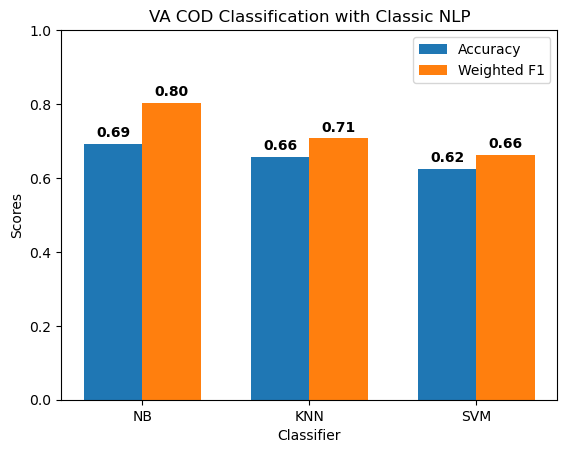

ap


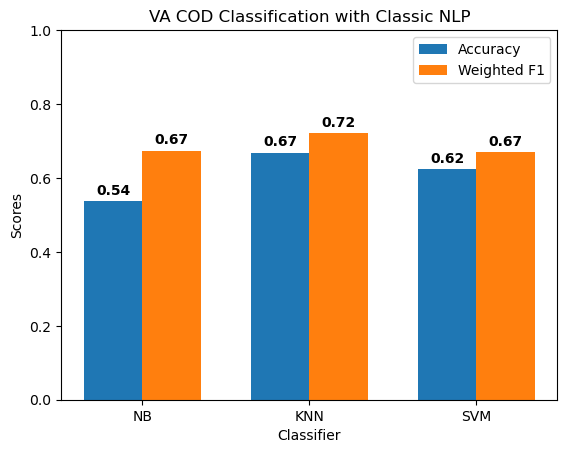

up


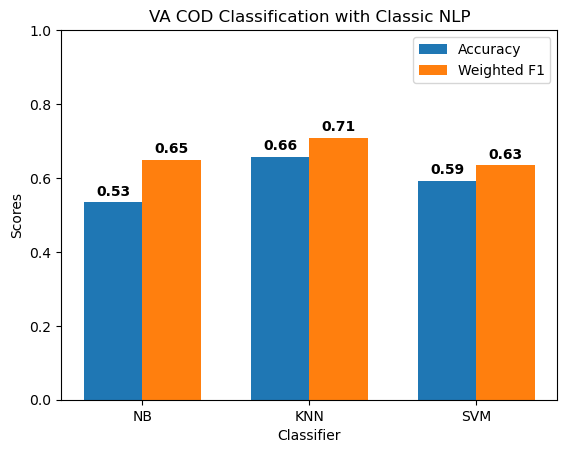

dar


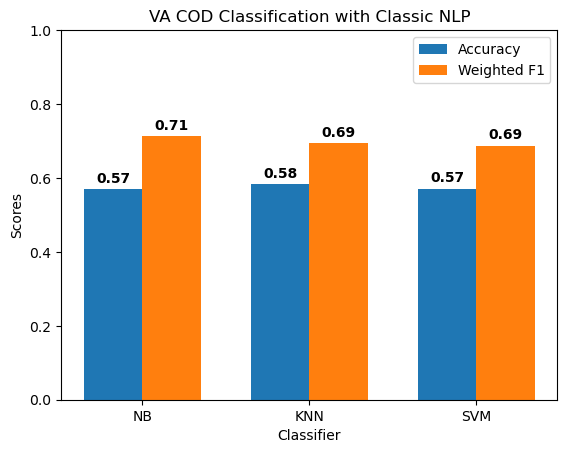

bohol


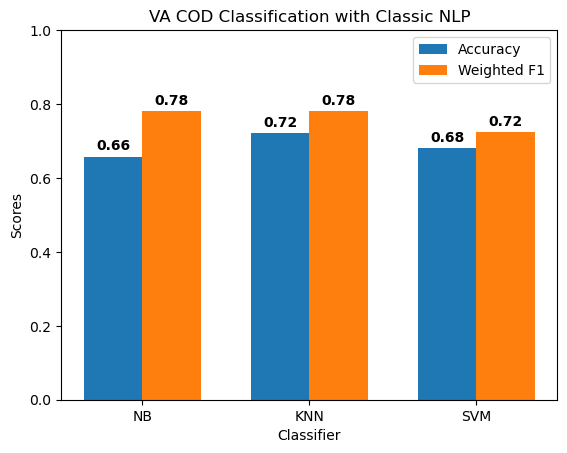

pemba


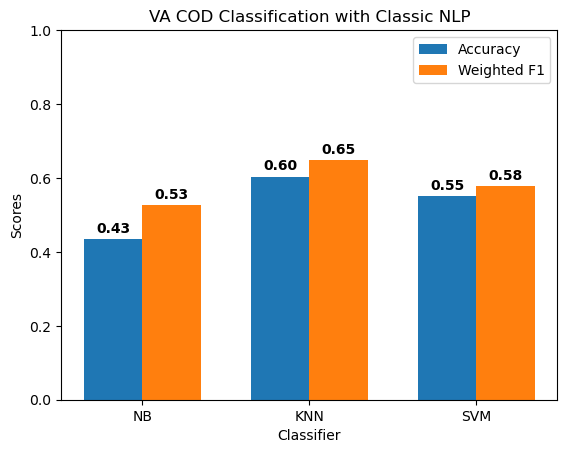

In [33]:
for site in tqdm(df['site'].unique()):
    print(site)
    
    # split into training and testing
    Test_X, Test_Y, Train_X, Train_Y, Test_X_covariates = split_data(input_site=site)
        
    # create embeddings from narratives text
    Train_X_Tfidf, Test_X_Tfidf = embeddings(Test_X, Test_Y, Train_X, Train_Y)
    
    # Fit and predict with Naive Bayes
    NB_accuracy, NB_weighted_f1, predictions_NB = NB_classifier(Train_X_Tfidf, Test_X_Tfidf, Train_Y, Test_Y)
    
    # Fit and predict with SVM
    SVM_accuracy, SVM_weighted_f1, predictions_SVM = SVM_classifier(Train_X_Tfidf, Test_X_Tfidf, Train_Y, Test_Y)
    
    # Fit and predict with KNN
    KNN_accuracy, KNN_weighted_f1, predictions_KNN = KNN_classifier(Train_X_Tfidf, Test_X_Tfidf, Train_Y, Test_Y)
    
    # compile the results from the three models
    accuracy_scores, weighted_f1_scores = compile_results(NB_accuracy, 
                                                          NB_weighted_f1, 
                                                          SVM_accuracy, 
                                                          SVM_weighted_f1, 
                                                          KNN_accuracy, 
                                                          KNN_weighted_f1)
    
    # print out results to csv
    predictions_df = pd.DataFrame({'Y': string_to_embedding(Test_Y),
                                   'X': Test_X_covariates,
                                   'Yhat_NB': predictions_NB,
                                   'Yhat_SVM': predictions_SVM, 
                                   'Yhat_KNN': predictions_KNN})
    
    predictions_df.to_csv(f'classic_predictions_ex_{site}.csv', index=False)
    
    # plot the results
    plot_compare(accuracy_scores, weighted_f1_scores)
    
    # MNlogit regress on covariates using predicted cause of death from each model and print summary
    # MNL_predict_on_cov(predictions_NB, predictions_SVM, predictions_KNN)

# break out by model and save to results folder

In [46]:
for site in tqdm(df['site'].unique()):
    # load
    temp_df = pd.read_csv(f'classic_predictions_ex_{site}.csv')
    
    # subset
    NB = temp_df[['Y', 'Yhat_NB', 'X']]
    KNN = temp_df[['Y', 'Yhat_KNN', 'X']]
    SVM = temp_df[['Y', 'Yhat_SVM', 'X']]
    
    # rename to Y_hat
    NB = NB.rename(columns={'Yhat_NB': 'Y_hat'})
    KNN = KNN.rename(columns={'Yhat_KNN': 'Y_hat'})
    SVM = SVM.rename(columns={'Yhat_SVM': 'Y_hat'})
    
    # export
    NB.to_csv(f'../../data/results/{site}_NB.csv', index=False)
    KNN.to_csv(f'../../data/results/{site}_KNN.csv', index=False)
    SVM.to_csv(f'../../data/results/{site}_SVM.csv', index=False)

  0%|          | 0/6 [00:00<?, ?it/s]